### Question 3

#### Imports

In [215]:
from numpy.ma.core import sqrt, ones, zeros, mean, std, sort, floor, round, prod
from numpy import fill_diagonal
from scipy import stats
import matplotlib.pyplot as plt

#### One-factor model template with infections

In [216]:
# One factor model
def simOneFactorInfectious(n, PD, EAD, LGD, rho, q):
    normDist = stats.norm(0, 1)
    z = normDist.rvs(1)  # systematic factor
    y = normDist.rvs(n)  # idiosyncratic factor
    rtilde = sqrt(rho)*z + sqrt(1-rho)*y # Asset values for obligors
    c = normDist.ppf(PD) # Critical thresholds for obligors
    default_1 = (rtilde < c)

    # Infectious defaults
    bernoulliDist = stats.bernoulli(q)
    Q = bernoulliDist.rvs((n, n)) # Generate infection matrix
    fill_diagonal(Q, 0) # Ensures no self-infections
    # for i in range(n): # Ensures no self-infections
    #     Q[i, i] = 0
    default_2 = 1 - prod(1 - default_1 * Q, axis = 1) # Infection in step 2

    # Combining both steps
    default = default_1 + default_2 - default_1 * default_2

    losses = default * EAD * LGD
    return sum(losses), sum(default)

In [217]:
# One factor model
def simOneFactorInfectious_optimized(n, PD, EAD, LGD, rho, q):
    normDist = stats.norm(0, 1)
    z = normDist.rvs(1)  # systematic factor
    y = normDist.rvs(n)  # idiosyncratic factor
    rtilde = sqrt(rho)*z + sqrt(1-rho)*y # Asset values for obligors
    c = normDist.ppf(PD) # Critical thresholds for obligors
    default_1 = (rtilde < c)

    # Infectious defaults
    bernoulliDist = stats.bernoulli(q)
    Q = bernoulliDist.rvs((n, n)) # Generate infection matrix
    fill_diagonal(Q, 0) # Ensures no self-infections
    # for i in range(n): # Ensures no self-infections
    #     Q[i, i] = 0]
    default_2 = zeros(n)
    for i in range(n):
        default_2[i] = 1 - prod(1 - default_1 * Q[i]) # Infection in step 2

    # Combining both steps
    default = default_1 + default_2 - default_1 * default_2

    losses = default * EAD * LGD
    return sum(losses), sum(default)

#### Simulation

In [209]:
# The bank portfolios, numbers are obtained from assignment description
portfolios = {
    "ANB AMOR": {
        "n": 8000,
        "EAD": ones(8000),
        "LGD": 0.25 * ones(8000),
        "PD": 0.01 * ones(8000),
        "rho": 0.25,
    },
    "NSN": {
        "n": 1017,
        "EAD": ones(1000).tolist() + [10]*10 + [50]*4 + [100]*2 + [500],
        "LGD": 0.5 * ones(1017),
        "PD": 0.02 * ones(1017),
        "rho": 0.25,
    },
    "ROBA": {
        "n": 1017,
        "EAD": ones(1000).tolist() + [10]*10 + [50]*4 + [100]*2 + [500],
        "LGD": 0.5 * ones(1017),
        "PD": ([0.0275]*1000 + [0.02]*10 + [0.0175]*4 + [0.015]*2 + [0.008]),
        "rho": 0.25,
    },
}

In [220]:
# Parameters
runs = 1000 # Number of simulation runs.
alpha = 0.99 # alpha-value
q = 0.001 # Infectious default parameter

Portfolio of ANB AMOR bank
Expected loss (EL): 145.98 (132.21, 159.76)
Unexpected loss (UL): 222.22 (208.45, 235.99)
Value-at-Risk (VaR): 1194.75 (1180.98, 1208.52)
Economic capital (EC): 1048.77 (1034.99, 1062.54)
Tail conditional expectation (TCE): 1313.08 (1299.31, 1326.86)


Portfolio of NSN bank
Expected loss (EL): 42.3 (37.42, 47.18)
Unexpected loss (UL): 78.78 (73.9, 83.66)
Value-at-Risk (VaR): 380.0 (375.12, 384.88)
Economic capital (EC): 337.7 (332.82, 342.58)
Tail conditional expectation (TCE): 507.39 (502.51, 512.27)


Portfolio of ROBA bank
Expected loss (EL): 43.54 (39.01, 48.07)
Unexpected loss (UL): 73.08 (68.55, 77.61)
Value-at-Risk (VaR): 397.5 (392.97, 402.03)
Economic capital (EC): 353.96 (349.43, 358.49)
Tail conditional expectation (TCE): 485.39 (480.86, 489.92)




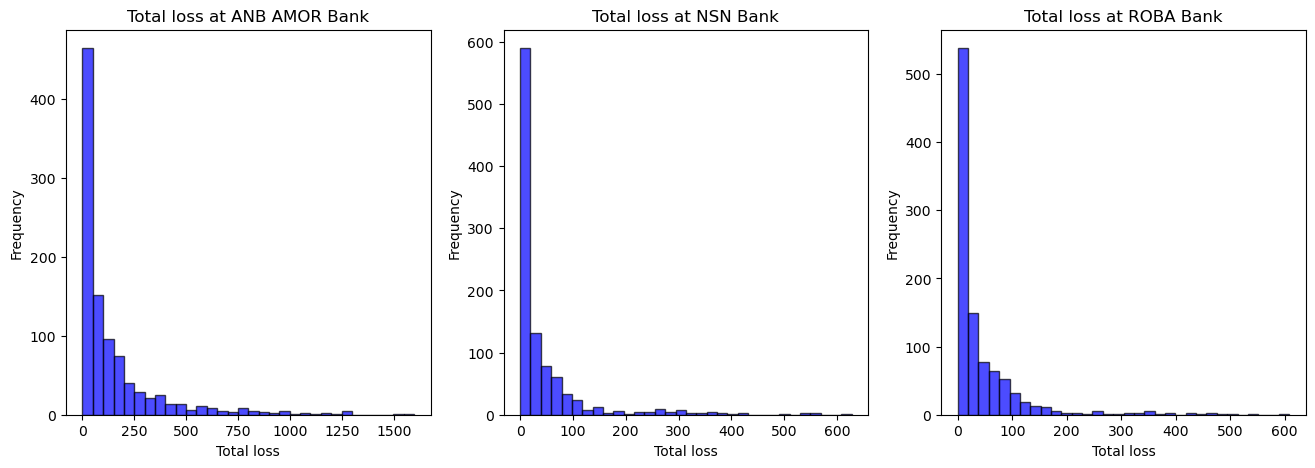

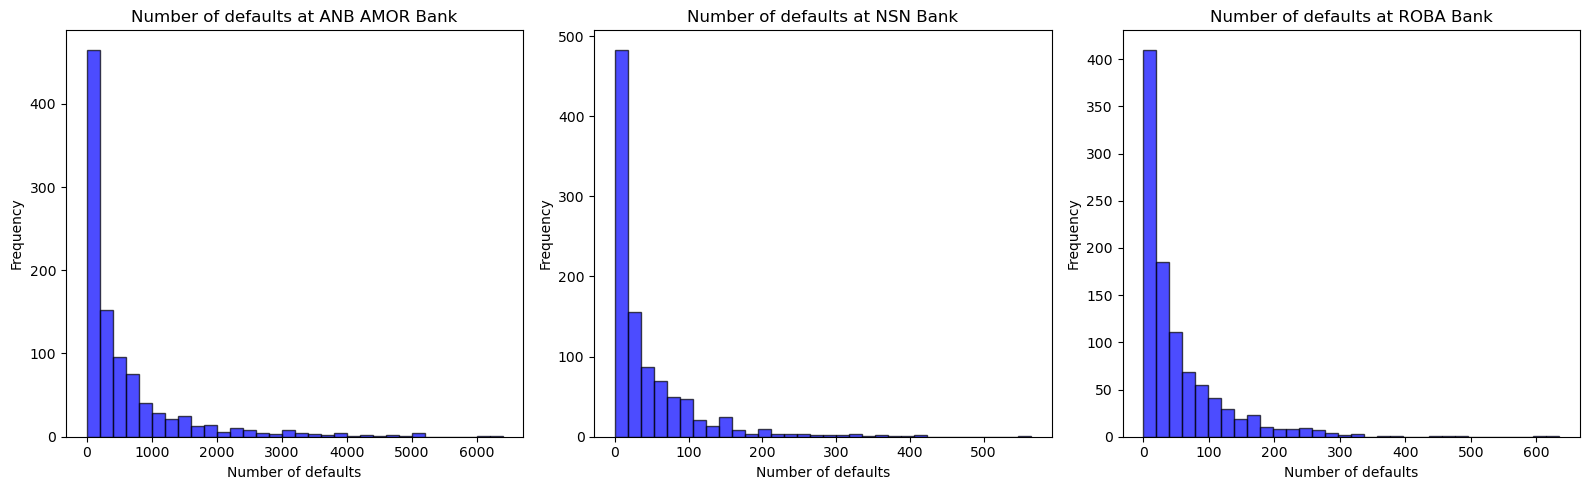

In [221]:
# Subplots
fig1, axes1 = plt.subplots(1, 3, figsize=(16, 5))
fig2, axes2 = plt.subplots(1, 3, figsize=(16, 5))

# The simulation for each portfolio
for idx, p in enumerate(portfolios):
    n = portfolios[p]["n"]
    EAD = portfolios[p]["EAD"]
    LGD = portfolios[p]["LGD"]
    PD = portfolios[p]["PD"]
    rho = portfolios[p]["rho"]
    
    losses = zeros(runs)
    defaults = zeros(runs)
    for i in range(runs):
        loss, default = simOneFactorInfectious(n, PD, EAD, LGD, rho, q)
        losses[i] = loss
        defaults[i] = default

    # Plot for total loss
    axes1[idx].hist(losses, bins=int(round(sqrt(runs))), color='blue', alpha=0.7, edgecolor='black')
    #axes1[idx].set_yscale('log')
    axes1[idx].set_title(f"Total loss at {p} Bank")
    axes1[idx].set_xlabel("Total loss")
    axes1[idx].set_ylabel("Frequency")

    # Plot for number of defaults
    axes2[idx].hist(defaults, bins=int(round(sqrt(runs))), color='blue', alpha=0.7, edgecolor='black')
    #axes2[idx].set_yscale('log')
    axes2[idx].set_title(f"Number of defaults at {p} Bank")
    axes2[idx].set_xlabel("Number of defaults")
    axes2[idx].set_ylabel("Frequency")

    # Calculate metrics
    EL = mean(losses)
    UL = std(losses)
  
    sortLosses = sort(losses)
    idx = int(floor(alpha * runs))
    VaR = sortLosses[idx] # Value-at-risk

    EC = VaR - EL # Economical capital
    TCE = mean(losses[losses > VaR]) # Tail conditional expectation

    # Confidence intervals (95%)
    z = 1.96
    EL_CI = [round(EL - z * (UL / sqrt(runs)), 2), round(EL + z * (UL / sqrt(runs)), 2)]
    UL_CI = [round(UL - z * (UL / sqrt(runs)), 2), round(UL + z * (UL / sqrt(runs)), 2)]
    VaR_CI = [round(VaR - z * (UL / sqrt(runs)), 2), round(VaR + z * (UL / sqrt(runs)), 2)]
    EC_CI = [round(EC - z * (UL / sqrt(runs)), 2), round(EC + z * (UL / sqrt(runs)), 2)]
    TCE_CI = [round(TCE - z * (UL / sqrt(runs)), 2), round(TCE + z * (UL / sqrt(runs)), 2)]

    # Print results with confidence intervals
    print(f"Portfolio of {p} bank")
    print(f"Expected loss (EL): {round(EL, 2)} ({EL_CI[0]}, {EL_CI[1]})")
    print(f"Unexpected loss (UL): {round(UL, 2)} ({UL_CI[0]}, {UL_CI[1]})")
    print(f"Value-at-Risk (VaR): {round(VaR, 2)} ({VaR_CI[0]}, {VaR_CI[1]})")
    print(f"Economic capital (EC): {round(EC, 2)} ({EC_CI[0]}, {EC_CI[1]})")
    print(f"Tail conditional expectation (TCE): {round(TCE, 2)} ({TCE_CI[0]}, {TCE_CI[1]})")
    print("\n")

plt.tight_layout()
plt.show()